# Implementación de la Atención

La atención es una técnica que se utiliza en las redes neuronales para mejorar la capacidad de los modelos de aprendizaje profundo para capturar relaciones a largo plazo. En este cuaderno, implementaremos dicho mecanismo siguiendo distintas arquitecturas de atención.

In [3]:
import torch.nn as nn
import torch
import torch.nn.functional as F

## Atención Simple: Producto escalar

La atención más simple en la que uno podría pensar es aquella que hace uso del producto escalar para determinar como de útiles son las palabras de una secuencia para predecir la siguiente palabra. En el caso de los modelos seq2seq, la atención se utiliza para modificar la salida del decodificador en función de las salidas del codificador. Esto se hace con el objetivo de que el decodificador pueda enfocarse en las partes más relevantes de la secuencia de entrada en la generación de la secuencia de salida.

En esta aproximación, esto se consigue calculando, en cada iteración del decoding, un vector de atención que se obtiene multiplicando la salida del decodificador en dicha iteración por el tensor resultante que contiene todas las salidas del codificador, lo cual es equivalente a un producto escalar.

Esto dará como resultado una matriz de puntuación, o de `scores`, que luego es pasada por una capa `Softmax` para normalizar los valores. Tendremos, en este punto, una matriz de dimensión $batch_{size}\times sequence_{len}$ que contiene, por así decirlo, la información de cómo de relevante es cada palabra de la secuencia de entrada para la generación de la palabra actual en el decoder.

Una vez hecho esto, se hace uso de la distribución de probabilidad resultante, la cual hemos obtenido para cada batch, para calcular un vector de contexto que se obtiene multiplicando la matriz de puntuación por las salidas del codificador. Este vector de contexto se obtiene sumando las columnas de la matriz resultante, lo cual nos dará un vector de dimensión $batch_{size}\times hidden_{size}$. Cada fila de esta matriz representa, para cada lote, una ponderación de las salidas del codificador en función de la palabra que se está generando en el decodificador.

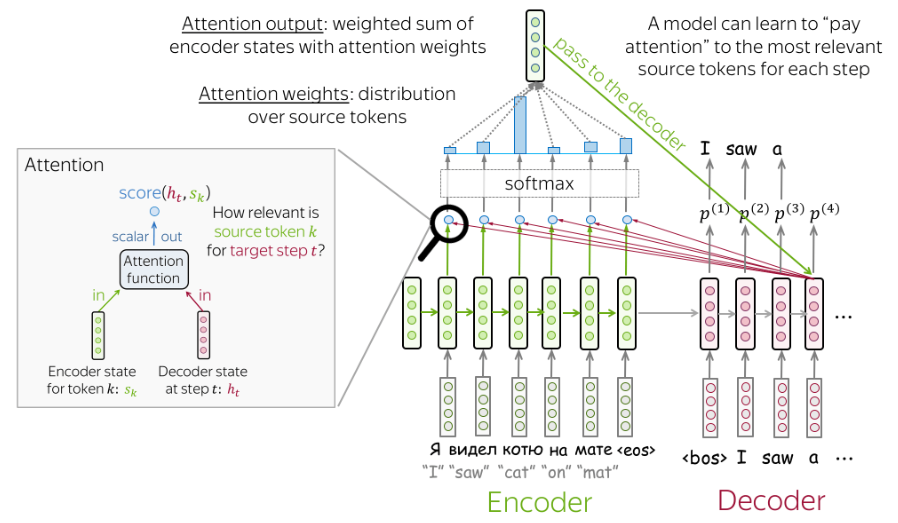

In [128]:
class DotAttention(nn.Module):
    def __init__(self):
        super(DotAttention, self).__init__()

    def forward(self, encoded_outputs, decoder_output):
        score = torch.bmm(encoded_outputs, decoder_output.unsqueeze(2)).squeeze()
        score = self.softmax(score)
        return torch.bmm(score.unsqueeze(1).float(), encoded_outputs.float()).squeeze()

    def softmax(self, score):
        try:
            score = torch.softmax(score.float(), dim=1)
        except:
            score = score.unsqueeze(0)
            score = F.softmax(score.float(), dim=0)
        return score

In [129]:
attention = DotAttention()

In [130]:
A = torch.randn(8, 2, 512)
b = torch.randn(8, 512)

In [131]:
A.shape, b.shape

(torch.Size([8, 2, 512]), torch.Size([8, 512]))

In [132]:
att = attention.forward(A, b)
print('Attention result', att, att.shape)

Attention result tensor([[-0.4421, -1.7852,  0.2027,  ..., -0.6643, -0.4826, -1.4242],
        [ 1.9843, -0.2155,  0.5705,  ..., -1.1340,  0.1400,  0.5160],
        [-0.0630, -0.7625, -0.3638,  ..., -1.7029, -0.3465, -0.9811],
        ...,
        [ 0.3859,  0.0661,  2.3362,  ...,  0.3276, -0.1348, -0.1324],
        [-1.3001, -1.5062, -0.0676,  ...,  0.5626, -0.4174,  0.5131],
        [ 2.9303, -0.5319,  1.5523,  ...,  0.5351,  0.2268, -0.8499]]) torch.Size([8, 512])


In [133]:
A = torch.tensor([[[1, 2, 3], [2, 2, 3]], [[4, 5, 6], [4, 5, 6]]])
b = torch.tensor([[7, 8, 9], [2, 1, 1]])

In [134]:
A.shape, b.shape

(torch.Size([2, 2, 3]), torch.Size([2, 3]))

In [135]:
att = attention.forward(A, b)
print('Attention result', att)

Attention result tensor([[1.9991, 2.0000, 3.0000],
        [4.0000, 5.0000, 6.0000]])


## Atención de Luong: Función bilineal

Con el objetivo de que la atención sea entrenable, y que por tanto el mecanismo sea capaz de adaptarse en función de los datos de entrenamiento y no únicamente de los embeddings utilizados, surge la atención de Luong. En este caso, en lugar de hacer uso de un producto escalar, se hace uso de una función bilineal para calcular los `scores` de atención. Matemáticamente, se calculan los `scores` de la siguiente forma:

$$
score(h_t, \bar{h}_s) = h_t^T W_a \bar{h}_s
$$

Donde ahora $h_t$ es el estado oculto del decodificador en la iteración $t$, $\bar{h}_s$ es la salida del codificador en la iteración $s$ y $W_a$ es una matriz de pesos que se entrena junto con el resto de la red. Es así dicha matriz $W_a$ la que permite que el mecanismo de atención se pueda adaptar a los datos de entrenamiento.

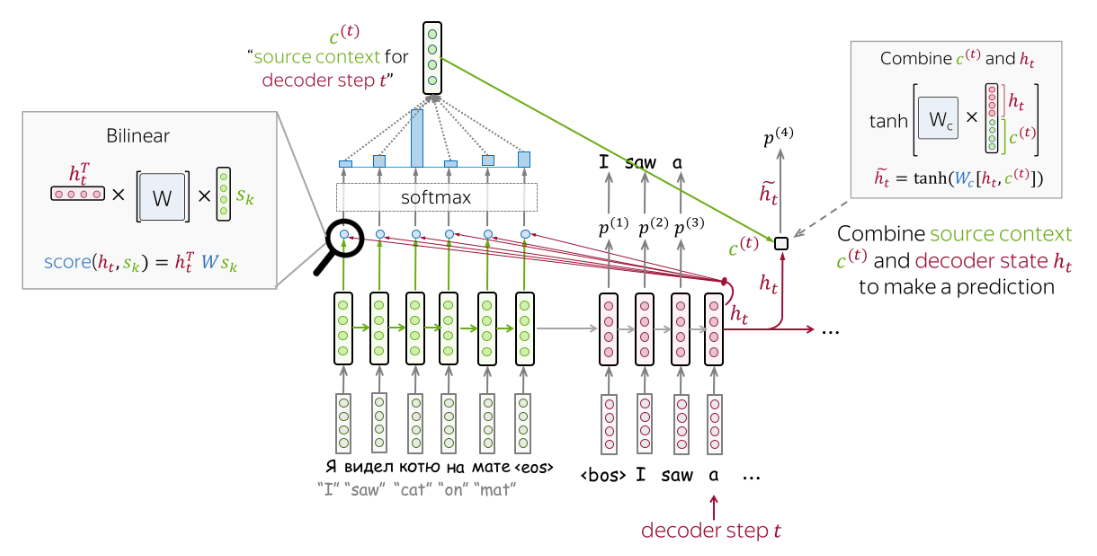

Tiene ahora más sentido que la clase `LuAttention`, la cual implementa la atención de Luong, herede de la clase `nn.Module`, dado que ahora tenemos una matriz de pesos que se entrena junto con el resto de la red y el cálculo de los gradientes debe añadirse al grafo de cómputo dinámico de PyTorch.

In [137]:
class LuAttention(nn.Module):
    def __init__(self, hidden_dim):
        super(LuAttention, self).__init__()
        self.W = nn.Parameter(torch.randn(hidden_dim, hidden_dim))

    def forward(self, encoded_outputs, decoder_output):
        score = self._get_scores(encoded_outputs.float(), decoder_output.float())
        return torch.bmm(
                        score.unsqueeze(1).float(),
                        encoded_outputs.float()
                ).squeeze()
    
    def _get_scores(self, encoded_outputs, decoder_output):
        ew = torch.matmul(encoded_outputs, self.W)
        score = torch.bmm(ew, decoder_output.unsqueeze(2)).squeeze()
        return self.softmax(score)

    def softmax(self, score):
        try:
            score = torch.softmax(score.float(), dim=1)
        except:
            score = score.unsqueeze(0)
            score = F.softmax(score.float(), dim=0)
        return score

In [138]:
attention = LuAttention(512)

In [139]:
A = torch.randn(8, 2, 512)
b = torch.randn(8, 512)

In [140]:
A.shape, b.shape

(torch.Size([8, 2, 512]), torch.Size([8, 512]))

In [141]:
att = attention.forward(A, b)
print('Attention result', att, att.shape)

Attention result tensor([[ 0.4522,  0.6863, -0.5545,  ...,  0.0906,  1.2650, -0.6792],
        [-0.5978,  0.1883, -0.1212,  ..., -0.3441, -1.6167, -3.1556],
        [ 0.2994, -1.9006, -0.1216,  ...,  1.2295, -1.1636,  1.5684],
        ...,
        [-1.1697,  1.0162, -0.6679,  ..., -0.0981, -0.0810, -1.4261],
        [-0.0572, -0.8257,  0.4873,  ..., -0.5860, -1.3902, -0.5297],
        [-0.8279, -0.8544, -0.8383,  ...,  0.7996, -1.1571,  0.5534]],
       grad_fn=<SqueezeBackward0>) torch.Size([8, 512])


In [142]:
attention = LuAttention(3)

In [143]:
A = torch.tensor([[[1, 2, 3], [2, 2, 3]], [[4, 5, 6], [4, 5, 6]]])
b = torch.tensor([[7, 8, 9], [2, 1, 1]])

In [144]:
A.shape, b.shape

(torch.Size([2, 2, 3]), torch.Size([2, 3]))

In [145]:
att = attention.forward(A, b)
print('Attention result', att, att.shape)

Attention result tensor([[1.2512, 2.0000, 3.0000],
        [4.0000, 5.0000, 6.0000]], grad_fn=<SqueezeBackward0>) torch.Size([2, 3])


A continuación, introducimos algunas mejoras en la implementación de la atención de Luong, calculando la atención de manera eficiente haciendo uso de una capa lineal.

In [9]:
class LuAttention(nn.Module):
    def __init__(self, hidden_dim):
        super(LuAttention, self).__init__()
        self.W = nn.Linear(hidden_dim, hidden_dim, bias=False)

    def forward(self, encoded_outputs, decoder_output):
        encoded_outputs = encoded_outputs.float()  # Aseguramos que sea float
        decoder_output = decoder_output.float()  # Aseguramos que sea float
        score = self._get_scores(encoded_outputs, decoder_output)
        return torch.bmm(
            score.unsqueeze(1),
            encoded_outputs
        ).squeeze(1)

    def _get_scores(self, encoded_outputs, decoder_output):
        ew = self.W(encoded_outputs)
        score = torch.bmm(ew, decoder_output.unsqueeze(2)).squeeze(2)
        return F.softmax(score, dim=1)

In [10]:
attention = LuAttention(3)

In [11]:
A = torch.tensor([[[1, 2, 3], [2, 2, 3]], [[4, 5, 6], [4, 5, 6]]])
b = torch.tensor([[7, 8, 9], [2, 1, 1]])

In [12]:
A.shape, b.shape

(torch.Size([2, 2, 3]), torch.Size([2, 3]))

In [13]:
att = attention.forward(A, b)
print('Attention result', att, att.shape)

Attention result tensor([[1.9073, 2.0000, 3.0000],
        [4.0000, 5.0000, 6.0000]], grad_fn=<SqueezeBackward1>) torch.Size([2, 3])


## Atención de Bahdanau: Perceptrón multicapa

Este tipo de atención permite añadir aún más parámetros a la red, lo cual puede ser útil en el caso de que se quiera añadir más complejidad al mecanismo de atención. En este caso, se hace uso de una red neuronal de una capa para calcular los `scores` de atención, y el resultado es a su vez multiplicado por un vector de pesos que también se entrena junto con el resto de la red. Matemáticamente, se calculan los `scores` de la siguiente forma:

$$
score(h_t, \bar{h}_s) = v_a^T \tanh(W_a [h_t; \bar{h}_s])
$$

Donde ahora $v_a$ es un vector de pesos que se entrena junto con el resto de la red y $W_a$ es una matriz de pesos que se entrena junto con el resto de la red. En el código, la matriz de pesos se referencia como `self.W1` y el vector de pesos como `self.w2`.

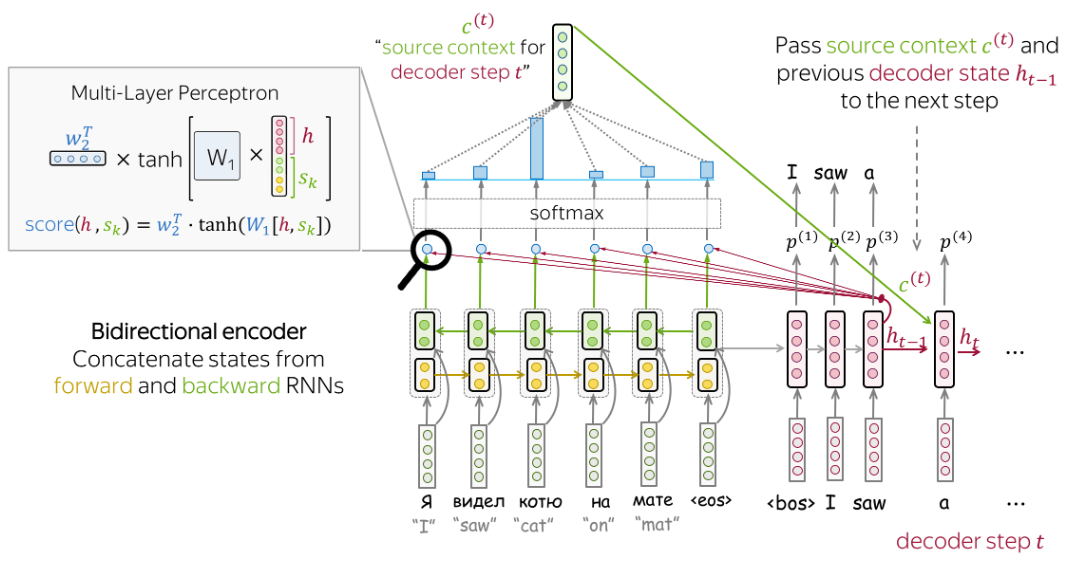

Además,  hay que tener en cuenta que el vector que se le pasa al perceptrón multicapa es la concatenación de los estados ocultos del decodificador y del codificador, lo cual se representa como $[h_t; \bar{h}_s]$.

In [162]:
class BaAttention(nn.Module):
    def __init__(self, hidden_dim):
        super(BaAttention, self).__init__()
        self.W1 = nn.Parameter(torch.randn(2*hidden_dim, 2*hidden_dim))
        self.w2 = nn.Parameter(torch.randn(1, 2*hidden_dim))
        self.hidden_dim = hidden_dim

    def forward(self, encoded_outputs, decoder_output):
        score = self._get_scores(encoded_outputs.float(), decoder_output.float())
        
        return torch.bmm(
                        score.unsqueeze(1).float(),
                        encoded_outputs.float()
                ).squeeze()
    
    def _get_scores(self, encoded_outputs, decoder_output):
        decoder_resized_output = decoder_output.unsqueeze(1).repeat(1, encoded_outputs.shape[1], 1)
        h = torch.cat((encoded_outputs, decoder_resized_output), dim=2)

        batch_size = encoded_outputs.shape[0]
        h = h.reshape((batch_size, self.hidden_dim*2, -1))
        w1_batch = self.W1.unsqueeze(0).repeat(batch_size, 1, 1)

        wh = torch.bmm(w1_batch, h)
        wh = torch.tanh(wh)

        w2_batch = self.w2.unsqueeze(0).repeat(batch_size, 1, 1)
        score = torch.bmm(w2_batch, wh).squeeze().reshape(batch_size, -1)

        return torch.softmax(score, dim=1)

In [163]:
attention = BaAttention(3)

In [164]:
A = torch.tensor([[[1, 2, 3], [2, 2, 3]], [[4, 5, 6], [4, 5, 6]]])
b = torch.tensor([[7, 8, 9], [2, 1, 1]])

In [165]:
att = attention.forward(A, b)
print('Attention result', att, att.shape)

Attention result tensor([[1.4998, 2.0000, 3.0000],
        [4.0000, 5.0000, 6.0000]], grad_fn=<SqueezeBackward0>) torch.Size([2, 3])


In [166]:
attention = BaAttention(512)

In [167]:
A = torch.randn(8, 3, 512)
b = torch.randn(8, 512)

In [168]:
A.shape, b.shape

(torch.Size([8, 3, 512]), torch.Size([8, 512]))

In [169]:
att = attention.forward(A, b)
print('Attention result', att, att.shape)

Attention result tensor([[-1.2852,  1.3491,  2.5996,  ..., -2.6342, -0.9571,  1.1209],
        [ 0.1541, -0.7315,  0.4040,  ...,  1.7009,  0.1613, -1.3594],
        [ 0.3824,  0.5140, -0.2490,  ...,  1.9464, -0.7057, -0.6272],
        ...,
        [ 1.0432, -0.3538, -0.6421,  ...,  0.1255, -0.9691, -1.5949],
        [ 0.1768, -1.7953, -0.5824,  ..., -1.3800, -1.2960, -2.7433],
        [-1.2452, -0.2957,  0.8056,  ...,  1.2165,  0.6274,  0.1707]],
       grad_fn=<SqueezeBackward0>) torch.Size([8, 512])


Si ahora introducimos las modificaciones necesarias para mejorar la implementación, obtenemos lo siguiente:

In [30]:
class BaAttention(nn.Module):
    def __init__(self, hidden_dim):
        super(BaAttention, self).__init__()
        self.W1 = nn.Linear(2 * hidden_dim, 2 * hidden_dim).float()
        self.w2 = nn.Linear(2 * hidden_dim, 1).float()
        self.hidden_dim = hidden_dim

    def forward(self, encoded_outputs, decoder_output):
        encoded_outputs = encoded_outputs.float()
        decoder_output = decoder_output.float()
        score = self._get_scores(encoded_outputs, decoder_output)
        return torch.bmm(score.unsqueeze(1), encoded_outputs).squeeze(1)

    def _get_scores(self, encoded_outputs, decoder_output):
        batch_size, seq_len, _ = encoded_outputs.size()
        decoder_expanded = decoder_output.unsqueeze(1)
        decoder_expanded = decoder_expanded.expand(-1, seq_len, -1)
        h = torch.cat((encoded_outputs, decoder_expanded), dim=2)
        wh = torch.tanh(self.W1(h))
        score = self.w2(wh).squeeze(2)
        return F.softmax(score, dim=1)

In [31]:
attention = BaAttention(3)

In [32]:
A = torch.tensor([[[1, 2, 3], [2, 2, 3]], [[4, 5, 6], [4, 5, 6]]])
b = torch.tensor([[7, 8, 9], [2, 1, 1]])

In [33]:
att = attention.forward(A, b)
print('Attention result', att, att.shape)

Attention result tensor([[1.4931, 2.0000, 3.0000],
        [4.0000, 5.0000, 6.0000]], grad_fn=<SqueezeBackward1>) torch.Size([2, 3])
